In [ ]:
#!pip install scikit-image
#!pip install opencv-python

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import morphology, io
from skimage.transform import rescale, resize, downscale_local_mean

import os

from skimage.segmentation import slic, mark_boundaries
from skimage import feature #for feature extraction

import cv2

import math
from skimage import transform


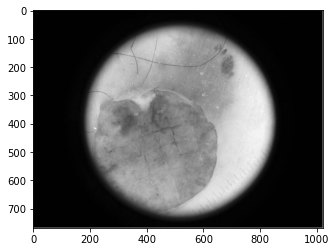

In [4]:
images = os.listdir('../data/ISIC_2017/Images_re')
segments = os.listdir('../data/ISIC_2017/custom_masks')
#Greyscaling
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

im = plt.imread('../data/ISIC_2017/Images_re/'+images[4])
mask = plt.imread('../data/ISIC_2017/custom_masks/'+segments[4])

gray = rgb2gray(im)
plt.imshow(gray,cmap='gray')

# Calculating features

8303.221257527668 %


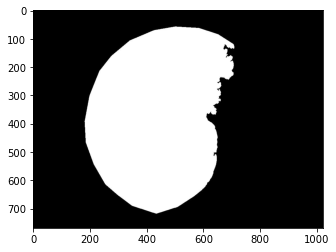

In [5]:
### Area of lesion using segment
# Total size of the image
total = mask.shape[0] * mask.shape[1] 

# Size of mask only
area = np.sum(mask)

# As percentage
print(area/total*100, "%")

plt.imshow(mask, cmap='gray')

65299189
250317
65048872


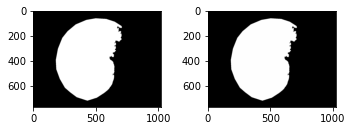

In [6]:
### Calculation perimeter using a brush

## Structural element, that we will use as a "brush" on our mask. The parameter is "brush size"
brush = morphology.disk(3)

# Use this "brush" to erode the image - eat away at the borders

mask_eroded = morphology.binary_erosion(mask, brush)

# Show side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify the new mask is smaller
new_area = np.sum(mask_eroded)

print(area)
print(new_area)

## As the new area is smaller, the perimeter is calculated by subtracting the og mask from the mask_eroded
# Subtract the two masks from each other to get the border/perimeter
# What is the length of this perimeter = how many 1s? 

image_perimeter = mask - mask_eroded
perimeter = np.sum(image_perimeter)
print(perimeter)

plt.imshow(image_perimeter, cmap='gray')


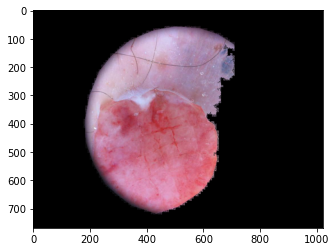

In [7]:
### Creating a version showing the lesion on top of the mask

img1 = im.copy()
img1[mask==0] = 0

plt.imshow(img1)

In [8]:
## We can make a zoomed in version using the mask later if this code is too complicated (also, plagarism?)

# https://stackoverflow.com/questions/59191179/finding-coordinates-of-corners-of-the-maskrectengular-shape-from-mask-matrixb

array = mask.copy()
H,W = array.shape

left_edges = np.where(array.any(axis=1),array.argmax(axis=1),W+1)
flip_lr = cv2.flip(array,1) #1 horz vert 0
right_edges = W - np.where(flip_lr.any(axis=1),flip_lr.argmax(axis=1),W+1)
top_edges = np.where(array.any(axis=0),array.argmax(axis=0),H+1)
flip_ud = cv2.flip(array,0) #1 horz vert 0
bottom_edges = H - np.where(flip_ud.any(axis=0),flip_ud.argmax(axis=0),H+1)

leftmost = left_edges.min()
rightmost = right_edges.max()
topmost = top_edges.min()
bottommost = bottom_edges.max()

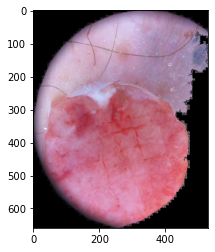

In [9]:
im2 = img1[topmost:bottommost,leftmost:rightmost,:]
mask2 = mask[topmost:bottommost,leftmost:rightmost]
plt.imshow(im2)

0.46670005428368166


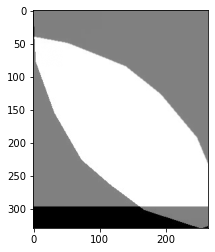

In [10]:
### Asymmetry
## if rotated lesion and lesion are overlapped and there exists a high value of gray, then the lesion is assymetric

#mask2 = morphology.disk(5)

h, w = map(int, mask2.shape)
left = mask2[0:, 0:math.floor(w/2)]
right = mask2[0:, math.ceil(w/2):]
rot_im = transform.rotate(right, 180) ##check if it rotates clockwise or counter clockwise
new_im = rot_im + left
new_im[new_im == 2] = 0

h2, w2 = map(int, new_im.shape)
top = new_im[0: math.floor(h2/2), 0:]
bottom = new_im[math.ceil(h2/2):, 0:]
rot_im2 = transform.rotate(top, 270)
new_im2 = rot_im2 + bottom
new_im2[new_im2 == 2] = 0

plt.imshow(new_im2, cmap='gray')
asymmetry = np.sum(new_im2)/(area)
print(asymmetry)

# number of grey pixels depends on the size of the lesion as well
# so even if the lesion is small, it would still have a lot of gray pixels
# so how would this work as a feature?

In [11]:
### Measuring shape with area and perimeter
## Compactness = l^2/(4pi*A) --> l = perimeter, A = area

c = (perimeter)**2/(4*math.pi*area)
print(c)

## the minimal the value of c (aka the close it is to 1), the more symmetric (circular) it is
# cannot be 1 perfectly due to pixels

# how is compactness different from symmetry
## why check assymetry? a hexagon is pretty symmetrical

5156581.526224518


In [12]:
### Measuring "average" color

# average luminance --> ?
# grayscale image and calculate average --> but what does this tell us? how is this feature valuable?

#calculating color features
colors_of_lesion = im2[mask2==1]
x_R, x_G, x_B = np.mean(colors_of_lesion, axis = 0)
print(x_R, x_G, x_B)

avg_color = (x_R + x_G + x_B)/3
print(avg_color)

120.41428571428571 95.63571428571429 116.48809523809524
110.84603174603176


In [14]:
Perimeter = []
Area = []
Avg_color = []
Compactness = []
Asymmetry = []
Asymmetry_02 = []
Red = []
Green = []
Blue = []

for i in range(len(images)):
    im = plt.imread('../data/ISIC_2017/Images_re/'+images[i])
    mask = (plt.imread('../data/ISIC_2017/custom_masks/'+segments[i])).copy()
    
    mask[0:3,:], mask[-4:-1,:], mask[:,0:3], mask[:,-4:-1] = False,False,False,False
    
    total = mask.shape[0] * mask.shape[1] 
    area = np.sum(mask)
    
    brush = morphology.disk(3)
    
    mask_eroded = morphology.binary_erosion(mask, brush)
    
    
    image_perimeter = mask - mask_eroded
    perimeter = np.sum(image_perimeter)
    
    img1 = im.copy()
    img1[mask==0] = 0
    
    c = (perimeter)**2/(4*math.pi*area)
    
    array = mask.copy()
    H,W = array.shape

    left_edges = np.where(array.any(axis=1),array.argmax(axis=1),W+1)
    flip_lr = cv2.flip(array,1)
    right_edges = W - np.where(flip_lr.any(axis=1),flip_lr.argmax(axis=1),W+1)
    top_edges = np.where(array.any(axis=0),array.argmax(axis=0),H+1)
    flip_ud = cv2.flip(array,0)
    bottom_edges = H - np.where(flip_ud.any(axis=0),flip_ud.argmax(axis=0),H+1)

    leftmost = left_edges.min()
    rightmost = right_edges.max()
    topmost = top_edges.min()
    bottommost = bottom_edges.max()
    
    im2 = img1[topmost:bottommost,leftmost:rightmost,:]
    mask2 = mask[topmost:bottommost,leftmost:rightmost]

    h, w = map(int, mask2.shape)
    left = mask2[0:, 0:math.floor(w/2)]
    right = mask2[0:, math.ceil(w/2):]
    rot_im = transform.rotate(right, 180)         
    new_im = rot_im + left
    new_im[new_im == 2] = 0

    h2, w2 = map(int, new_im.shape)
    top = new_im[0: math.floor(h2/2), 0:]
    bottom = new_im[math.ceil(h2/2):, 0:]
    rot_im2 = transform.rotate(top, 270)
    new_im2 = rot_im2 + bottom
    new_im2[new_im2 == 2] = 0
    
    asymmetry = np.sum(new_im2)/area
    

    colors_of_lesion = im2[mask2==1]
    x_R, x_G, x_B = np.mean(colors_of_lesion, axis = 0)

    avg_color = (x_R + x_G + x_B)/3
    
    Perimeter.append(perimeter)
    Area.append(area)
    Avg_color.append(avg_color)
    Compactness.append(c)
    Red.append(x_R)
    Green.append(x_G)
    Blue.append(x_B)
    Asymmetry.append(asymmetry)

In [15]:
features = pd.read_csv("../data/ISIC_2017/ISIC-2017_Training_Part3_GroundTruth.csv")
age_and_sex = pd.read_csv("../data/ISIC_2017/ISIC-2017_Training_Data_metadata.csv")

features["Perimeter"] = Perimeter
features["Area"] = Area
features["Compactness"] = Compactness
features["Asymmetry"] = Asymmetry
features["Red"] = Red
features["Green"] = Green
features["Blue"] = Blue
features["Average Color"] = Avg_color
features["Age"] = [int(a) if a != "unknown" else None for a in age_and_sex["age_approximate"]]
features["Sex"] = [0 if s == "male" else 1 for s in age_and_sex["sex"]]
features

,image_id,melanoma,seborrheic_keratosis,Perimeter,Area,Compactness,Asymmetry,Red,Green,Blue,Average Color,Age,Sex
0,ISIC_0000000,0.0,0.0,74078427,74362749,5.872435e+06,0.393262,128.737132,118.722426,124.130515,123.863358,55.0,1
1,ISIC_0000001,0.0,0.0,13617376,13669098,1.079536e+06,0.496562,142.195730,121.921708,107.711744,123.943060,30.0,1
2,ISIC_0000002,1.0,0.0,53395235,53597339,4.233036e+06,0.568722,151.246729,151.704673,173.800000,158.917134,60.0,1
3,ISIC_0000003,0.0,0.0,59188375,59415280,4.692074e+06,0.519714,180.681481,150.597531,124.259259,151.846091,30.0,0
4,ISIC_0000004,1.0,0.0,65048872,65299189,5.156582e+06,0.466700,120.414286,95.635714,116.488095,110.846032,80.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,135335679,135857251,1.072833e+07,0.412467,173.908316,93.722814,82.288913,116.640014,75.0,0
1996,ISIC_0015233,0.0,1.0,47282195,47462639,3.748293e+06,0.481846,195.198966,135.731266,111.196382,147.375538,60.0,0
1997,ISIC_0015260,0.0,1.0,29251784,29361275,2.319102e+06,0.441650,114.686461,77.204276,49.710214,80.533650,55.0,1
1998,ISIC_0015284,1.0,0.0,68005725,68264091,5.391241e+06,0.534114,173.384915,130.383615,117.600780,140.456437,75.0,0


In [16]:
features.to_csv("../data/ISIC_2017/features.csv", index = False)

In [17]:
norm_features = features.copy()
for column in norm_features[['Compactness','Asymmetry','Average Color','Age']]:
    print(norm_features[column].abs().max())
    norm_features[column] = norm_features[column] /norm_features[column].abs().max()
    norm_features.columns = norm_features.columns.str.replace(column, 'Norm_'+column)
norm_features.to_csv("../data/ISIC_2017/norm_features.csv", index = False)

13524303.661695108
0.6949959819161972
241.51572327044025
85.0


In [18]:
norm_features

,image_id,melanoma,seborrheic_keratosis,Perimeter,Area,Norm_Compactness,Norm_Asymmetry,Red,Green,Blue,Norm_Average Color,Norm_Age,Sex
0,ISIC_0000000,0.0,0.0,74078427,74362749,0.434213,0.565848,128.737132,118.722426,124.130515,0.512858,0.647059,1
1,ISIC_0000001,0.0,0.0,13617376,13669098,0.079822,0.714482,142.195730,121.921708,107.711744,0.513188,0.352941,1
2,ISIC_0000002,1.0,0.0,53395235,53597339,0.312995,0.818309,151.246729,151.704673,173.800000,0.657999,0.705882,1
3,ISIC_0000003,0.0,0.0,59188375,59415280,0.346936,0.747794,180.681481,150.597531,124.259259,0.628721,0.352941,0
4,ISIC_0000004,1.0,0.0,65048872,65299189,0.381283,0.671515,120.414286,95.635714,116.488095,0.458960,0.941176,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ISIC_0015220,0.0,1.0,135335679,135857251,0.793263,0.593482,173.908316,93.722814,82.288913,0.482950,0.882353,0
1996,ISIC_0015233,0.0,1.0,47282195,47462639,0.277152,0.693308,195.198966,135.731266,111.196382,0.610211,0.705882,0
1997,ISIC_0015260,0.0,1.0,29251784,29361275,0.171477,0.635471,114.686461,77.204276,49.710214,0.333451,0.647059,1
1998,ISIC_0015284,1.0,0.0,68005725,68264091,0.398634,0.768514,173.384915,130.383615,117.600780,0.581562,0.882353,0
